<h1> Title: Emotion Recognition in text</h1>

<strong>Overview: In this notebook, I aim to detect and categorize emotion in text using GoEmotions datasets</strong><br>
In this notebook, it covers:<br>
1.0 Obtain and combine necessary data from original GoEmotions datasets<br>
2.0 Data understanding<br>
3.0 Text Preprocessing<br>
4.0 Data Splitting<br>
5.0 Model Development<br>
5.1 Transformer models<br>
6.0 Deployment<br>


Characteristics of GoEmotions:
- Application Domain: social media
- Size: 58,009 sentences
- Imbalanced
- Multi-label
- Emotion labeled: admiration, amusement, anger, annoyance, approval, caring, confusion, curiosity, desire, disappointment, disapproval, disgust, embarrassment, excitement, fear, gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief, remorse, sadness, surprise, neutral

In [ ]:
# Basic Libraries
import pandas as pd  
import numpy as np  
import random  
import warnings  
import json

# Text Processing Libraries
import nltk  
import contractions  
import re  
from collections import Counter  # Word frequency counting

# Tokenization, Stopwords, Stemming, and Lemmatization
from nltk.tokenize import word_tokenize  
from nltk.corpus import stopwords, wordnet  
from nltk.stem import PorterStemmer, WordNetLemmatizer  

# Data Splitting & Sampling Libraries
from skmultilearn.model_selection import IterativeStratification
from sklearn.utils.class_weight import compute_class_weight  

# Multilabel Classification Libraries
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer

# Transformer-Based Libraries
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW

# Statistical mode function
from scipy.stats import mode  

# File Handling & Serialization
import pickle  # Save and load Python objects
import os  # OS file operations
from pathlib import Path  # Path management
import joblib

# Data Visualization Libraries
import seaborn as sns 
import matplotlib.pyplot as plt  
from wordcloud import WordCloud  # Word cloud generation

# Performance Evaluation Metrics
from sklearn.metrics import (
    f1_score, hamming_loss, jaccard_score, f1_score, classification_report, precision_recall_curve, roc_auc_score
)  

# Ignore Warnings
warnings.filterwarnings("ignore")

# Download Required NLTK Resources
nltk.download('punkt')  # Tokenization
nltk.download('stopwords')  # Stopwords list
nltk.download('averaged_perceptron_tagger')  # POS tagging
nltk.download('wordnet')  # WordNet corpus for lemmatization
nltk.download('omw-1.4')  # WordNet synonyms

---
# 1.0 Obtain dataset
- The dataset is obtained from goemotions_1.csv, goemotions_2.csv, goemotions_3.csv and stored in separate GoEmotions.csv.

In [ ]:
file_paths = [
    '../Datasets/goemotions_1.csv',
    '../Datasets/goemotions_2.csv',
    '../Datasets/goemotions_3.csv'
]

# Define emotion columns (28 emotions)
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

# Load and combine datasets
dfs = []
for f in file_paths:
    df = pd.read_csv(f)
    
    # Ensure emotion columns exist
    for col in emotion_columns:
        if col not in df.columns:
            df[col] = 0  # Add missing emotion column
    dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

# Calculate label distribution
combined_df['label_sum'] = combined_df[emotion_columns].sum(axis=1)
print("Emotion label distribution for each text:")
print(combined_df['label_sum'].value_counts().sort_index())

Emotion label distribution for each text:
label_sum
0       3411
1     171820
2      31187
3       4218
4        399
5        106
6         53
7         20
8          6
9          3
10         1
12         1
Name: count, dtype: int64


In [20]:
records = []
skipped_count = 0

for _, row in combined_df.iterrows():
    text = row['text']
    vector = row[emotion_columns].values.astype(int)
    active_labels = [emotion for emotion, val in zip(emotion_columns, vector) if val == 1]
    
    # Handle unlabeled examples (no labels including neutral)
    if len(active_labels) == 0:
        skipped_count += 1
        continue  # Skip truly unlabeled examples
        
    records.append({
        'text': text,
        'emotion': active_labels,
        'vector': vector.tolist() 
    })

# Create final DataFrame
final_df = pd.DataFrame(records)

# Save to CSV
final_df.to_csv('../Datasets/GoEmotions.csv', index=False)

print(f"- Original dataset size: {len(combined_df)}")
print(f"- Unlabeled texts: {skipped_count}")
print(f"- Final dataset size: {len(final_df)}")

- Original dataset size: 211225
- Unlabeled texts: 3411
- Final dataset size: 207814


---
# 2.0 Data understanding

In [ ]:
# Load GoEmotions.csv
emotion_columns = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]
df = pd.read_csv('../Datasets/GoEmotions.csv', converters={'emotion': eval, 'vector': eval})
df

,text,emotion,vector
0,That game hurt.,[sadness],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"You do right, if you don't care then fuck 'em!",[neutral],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Man I love reddit.,[love],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[NAME] was nowhere near them, he was by the Fa...",[neutral],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Right? Considering it’s such an important docu...,[gratitude],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
207809,"Well, I'm glad you're out of all that now. How...",[joy],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
207810,Everyone likes [NAME].,[love],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
207811,Well when you’ve imported about a gazillion of...,[caring],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
207812,That looks amazing,[admiration],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [3]:
df.head()

,text,emotion,vector
0,That game hurt.,[sadness],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"You do right, if you don't care then fuck 'em!",[neutral],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Man I love reddit.,[love],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[NAME] was nowhere near them, he was by the Fa...",[neutral],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Right? Considering it’s such an important docu...,[gratitude],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [3]:
print('Dataset size:',df.shape)
print('Columns are:',df.columns)

Dataset size: (207814, 3)
Columns are: Index(['text', 'emotion', 'vector'], dtype='object')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207814 entries, 0 to 207813
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     207814 non-null  object
 1   emotion  207814 non-null  object
 2   vector   207814 non-null  object
dtypes: object(3)
memory usage: 4.8+ MB



Label Distribution Analysis


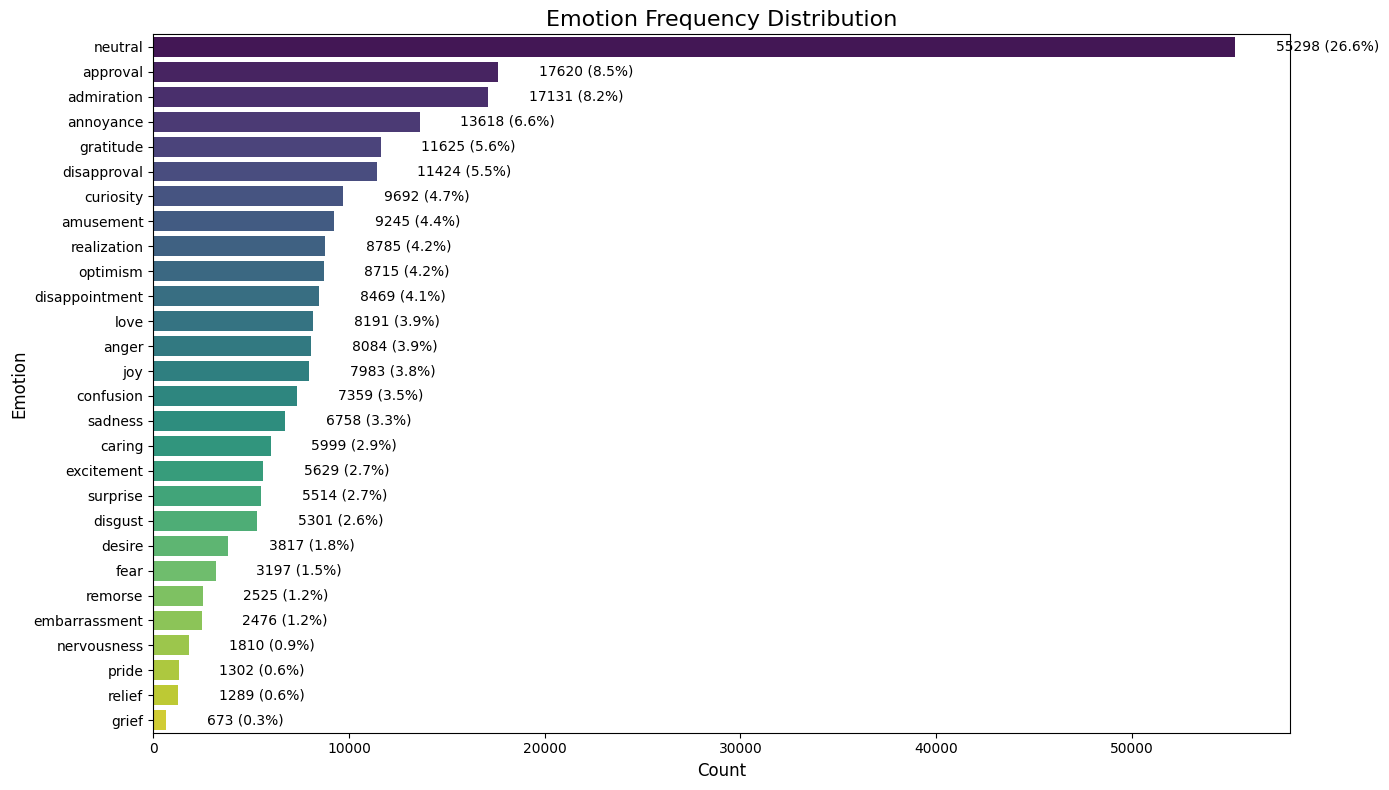


Emotion Frequency Table:
       Emotion  Count  Percentage
       neutral  55298       26.61
      approval  17620        8.48
    admiration  17131        8.24
     annoyance  13618        6.55
     gratitude  11625        5.59
   disapproval  11424        5.50
     curiosity   9692        4.66
     amusement   9245        4.45
   realization   8785        4.23
      optimism   8715        4.19
disappointment   8469        4.08
          love   8191        3.94
         anger   8084        3.89
           joy   7983        3.84
     confusion   7359        3.54
       sadness   6758        3.25
        caring   5999        2.89
    excitement   5629        2.71
      surprise   5514        2.65
       disgust   5301        2.55
        desire   3817        1.84
          fear   3197        1.54
       remorse   2525        1.22
 embarrassment   2476        1.19
   nervousness   1810        0.87
         pride   1302        0.63
        relief   1289        0.62
         grief    673 

In [ ]:
# Label Distribution Analysis
print("\n" + "="*50)
print("Label Distribution Analysis")
print("="*50)

# Create a matrix of emotions
emotion_matrix = np.array(df['vector'].tolist())
emotion_counts = emotion_matrix.sum(axis=0)
emotion_freq = pd.Series(emotion_counts, index=emotion_columns).sort_values(ascending=False)

# Plot emotion frequency
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=emotion_freq.values, y=emotion_freq.index, palette="viridis")
plt.title('Emotion Frequency Distribution', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Emotion', fontsize=12)

# Add percentage annotations
total = len(df)
for i, v in enumerate(emotion_freq.values):
    ax.text(v + total*0.01, i, f'{v} ({v/total:.1%})', 
            color='black', va='center', fontsize=10)
plt.tight_layout()
plt.show()

# Print frequency of each emotion
print("\nEmotion Frequency Table:")
emotion_freq_df = emotion_freq.reset_index()
emotion_freq_df.columns = ['Emotion', 'Count']
emotion_freq_df['Percentage'] = (emotion_freq_df['Count'] / total * 100).round(2)

print(emotion_freq_df.to_string(index=False))


Multi-Label Analysis


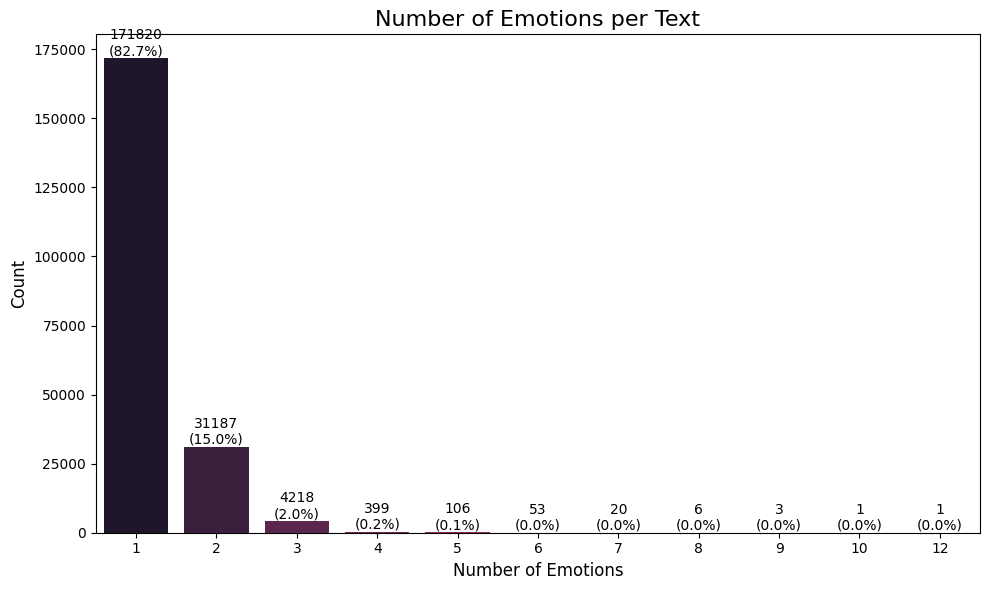

Texts with single emotion: 171820 (82.7%)
Maximum emotions in one text: 12


In [7]:
# Multi-Label Analysis
print("\n" + "="*50)
print("Multi-Label Analysis")
print("="*50)

# Number of labels per text
label_counts = emotion_matrix.sum(axis=1)
count_dist = pd.Series(label_counts).value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=count_dist.index, y=count_dist.values, palette="rocket")
plt.title('Number of Emotions per Text', fontsize=16)
plt.xlabel('Number of Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add annotations
for i, v in enumerate(count_dist.values):
    plt.text(i, v + 1000, f'{v}\n({v/total:.1%})', 
             ha='center', color='black', fontsize=10)
plt.tight_layout()
plt.show()

print(f"Texts with single emotion: {count_dist[1]} ({count_dist[1]/total:.1%})")
print(f"Maximum emotions in one text: {label_counts.max()}")


Emotion Co-occurrence Analysis


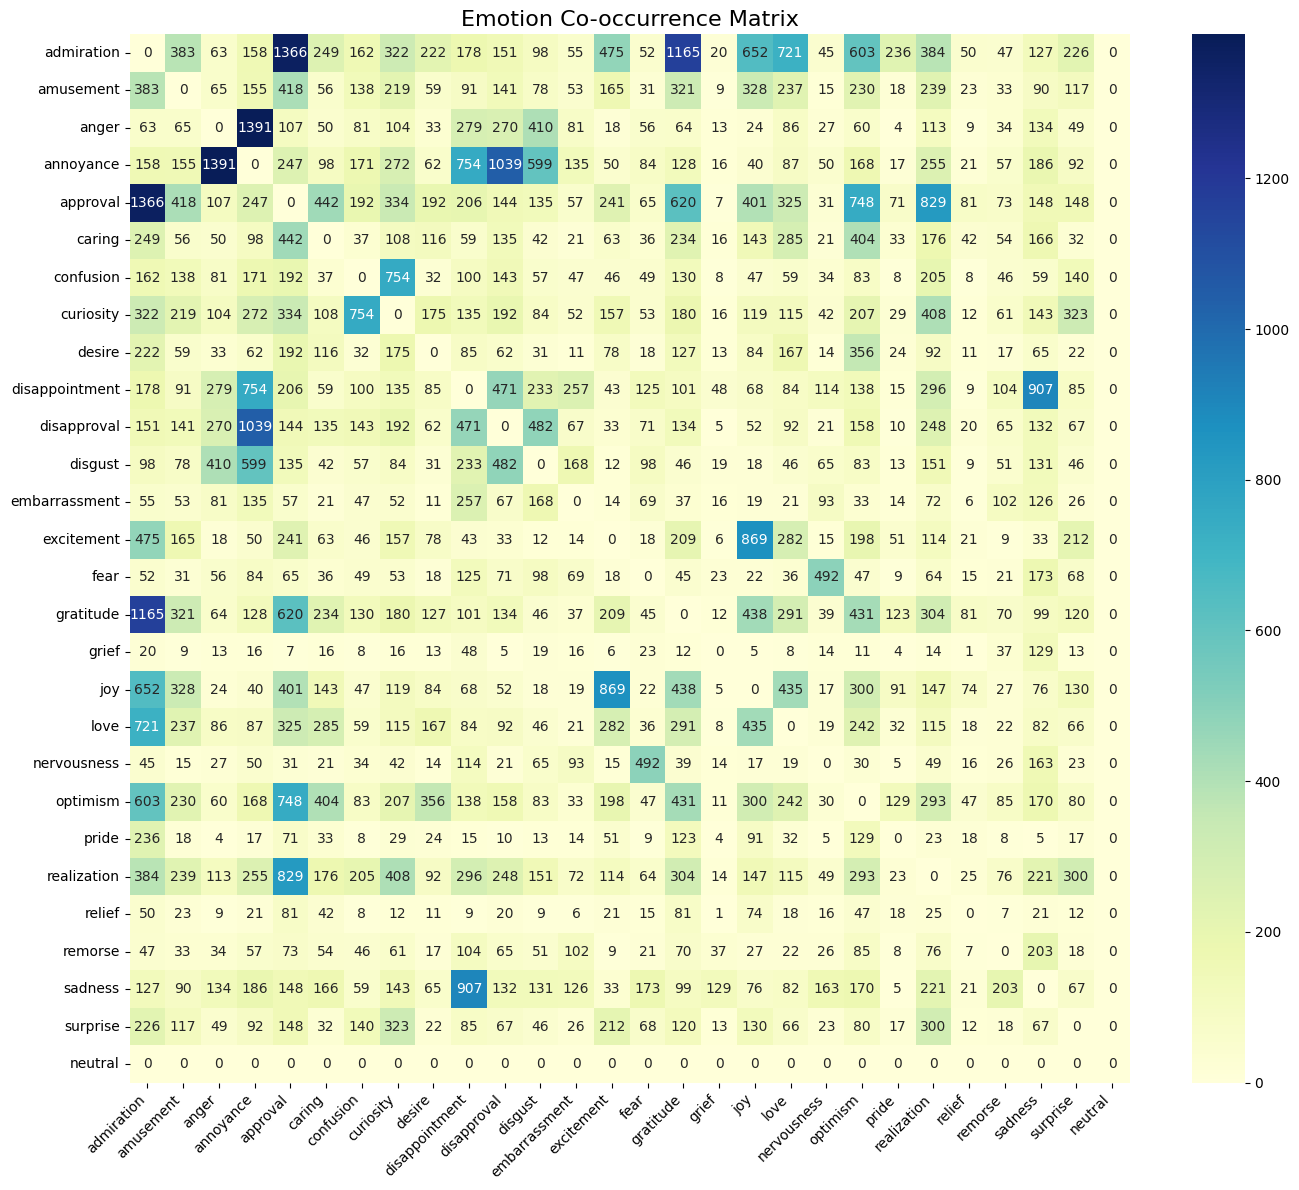


Top Co-occurring Emotion Pairs (Unique):
          Emotion1        Emotion2   Count
0            anger       annoyance  1391.0
1       admiration        approval  1366.0
2       admiration       gratitude  1165.0
3        annoyance     disapproval  1039.0
4   disappointment         sadness   907.0
5       excitement             joy   869.0
6         approval     realization   829.0
7        annoyance  disappointment   754.0
8        confusion       curiosity   754.0
9         approval        optimism   748.0
10      admiration            love   721.0
11      admiration             joy   652.0
12        approval       gratitude   620.0
13      admiration        optimism   603.0
14       annoyance         disgust   599.0


In [8]:
# Co-occurrence Analysis
print("\n" + "="*50)
print("Emotion Co-occurrence Analysis")
print("="*50)

# Create co-occurrence matrix
cooccurrence = emotion_matrix.T @ emotion_matrix
np.fill_diagonal(cooccurrence, 0)  # Remove self-counts

# Visualize the full matrix (keeping symmetry for visualization)
plt.figure(figsize=(14, 12))
sns.heatmap(cooccurrence, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=emotion_columns, 
            yticklabels=emotion_columns)
plt.title('Emotion Co-occurrence Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Get upper triangle only to avoid duplicate pairs
cooccurrence_df = pd.DataFrame(cooccurrence, 
                             columns=emotion_columns, 
                             index=emotion_columns)
mask = np.triu(np.ones(cooccurrence_df.shape), k=1).astype(bool)
stacked = cooccurrence_df.where(mask).stack().reset_index()
stacked.columns = ['Emotion1', 'Emotion2', 'Count']

# Filter and sort
top_pairs = stacked[stacked['Count'] > 0].sort_values('Count', ascending=False).head(15)

print("\nTop Co-occurring Emotion Pairs (Unique):")
print(top_pairs.reset_index(drop=True))

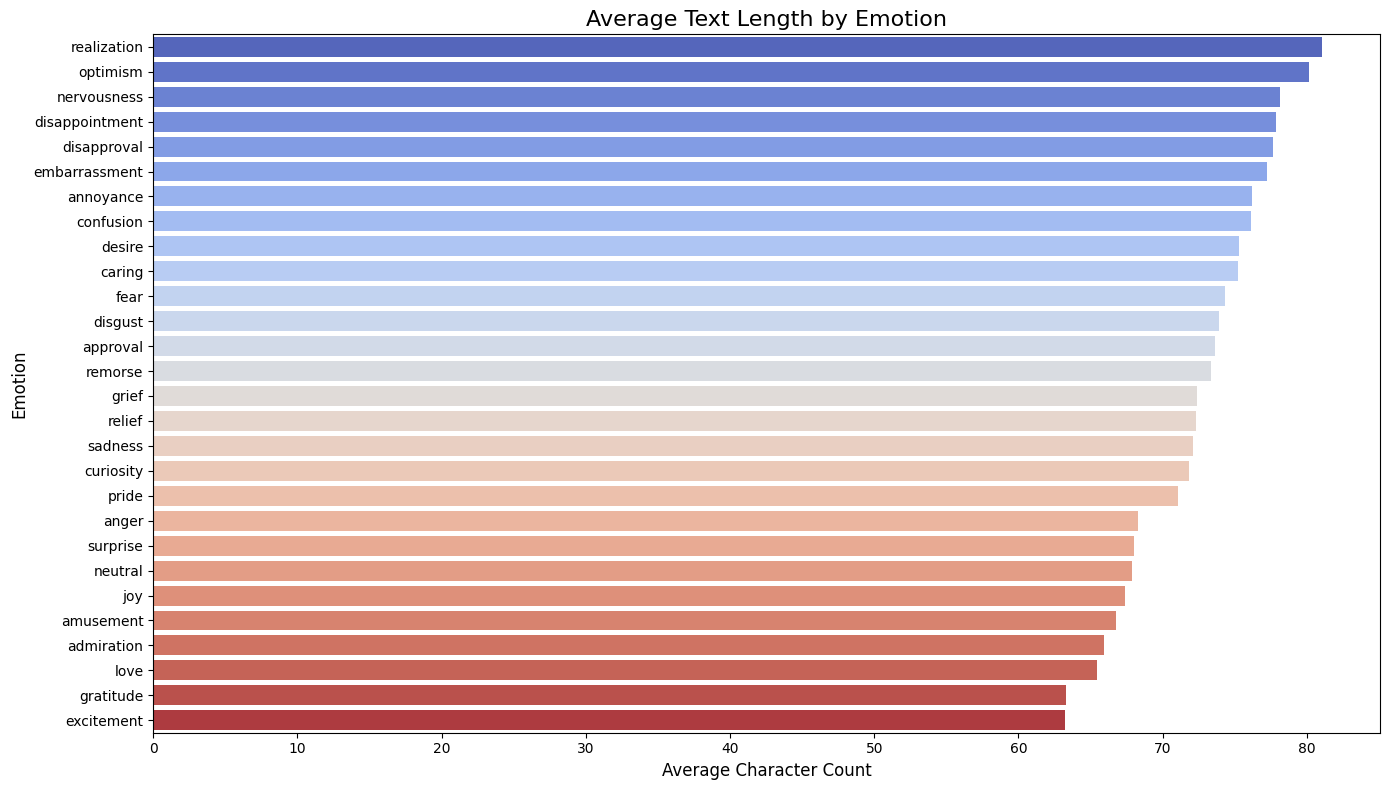


Emotions with longest texts:
           Emotion  Avg_Length
22     realization   81.016505
20        optimism   80.129891
19     nervousness   78.102210
9   disappointment   77.870587
10     disapproval   77.666317

Emotions with shortest texts:
       Emotion  Avg_Length
1    amusement   66.795890
0   admiration   65.911447
18        love   65.472470
15   gratitude   63.261849
13  excitement   63.199858


In [10]:
# Emotion Correlation with Text Length
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(14, 8))
emotion_lengths = []
for emotion in emotion_columns:
    lengths = df[df['vector'].apply(lambda x: x[emotion_columns.index(emotion)] == 1)]['text_length']
    emotion_lengths.append(lengths.mean())

length_df = pd.DataFrame({
    'Emotion': emotion_columns,
    'Avg_Length': emotion_lengths
}).sort_values('Avg_Length', ascending=False)

sns.barplot(x='Avg_Length', y='Emotion', data=length_df, palette='coolwarm')
plt.title('Average Text Length by Emotion', fontsize=16)
plt.xlabel('Average Character Count', fontsize=12)
plt.ylabel('Emotion', fontsize=12)
plt.tight_layout()
plt.show()

print("\nEmotions with longest texts:")
print(length_df.head(5))
print("\nEmotions with shortest texts:")
print(length_df.tail(5))

---
# 3.0 Text preprocessing
- Lowercasing
- Expanding contractions
- Expanding short forms 
- Removing punctuation, special characters, digits
- Tokenization
- Handling negations
- POS tagging
- Stemming and Lemmatization
- Removing stopwords
- Data augmentation such as paraphrasing and synonym replacement

In [ ]:
# Lowercase
df['text'] = df['text'].str.lower()

In [ ]:
# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

df['text'] = df['text'].apply(expand_contractions)
df['text'][:5]

0                                      that game hurt.
1     you do right, if you do not care then fuck them!
2                                   man i love reddit.
3    [name] was nowhere near them, he was by the fa...
4    right? considering it is such an important doc...
Name: text, dtype: object

In [ ]:
# Expand short forms
with open("../shortform_dict.json", "r") as f:
    shortform_dict = json.load(f)

def expand_shortforms(text, shortform_dict):
    def replace(match):
        word = match.group(0)
        return shortform_dict.get(word.lower(), word)

    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in shortform_dict.keys()) + r')\b', flags=re.IGNORECASE)
    return pattern.sub(replace, text)

df['text'] = df['text'].apply(expand_shortforms, shortform_dict=shortform_dict)
df['text'][:5]

0                                      that game hurt.
1     you do right, if you do not care then fuck them!
2                                   man i love reddit.
3    [name] was nowhere near them, he was by the fa...
4    right? considering it is such an important doc...
Name: text, dtype: object

In [ ]:
# Remove punctuation, special characters, digits, emojis, and extra whitespace
def clean_text(text):
    text = re.sub(r'\[name\]', '', text)  # Remove [NAME]
    # text = re.sub(r'\[.*?\]', '', text)  # Remove [NAME], [URL], etc.
    
    text = re.sub(r'[-—]', ' ', text) # Replace hyphens/dashes with spaces to avoid merged words
    
    text = text.encode('ascii', 'ignore').decode('ascii')  # Remove non-ASCII

    text = re.sub(r'[^a-zA-Z\s]', '', text) # Keep only letters and spaces

    text = ' '.join(text.split())  # Clean whitespace
    return text

df['text'] = df['text'].apply(clean_text)

In [ ]:
# Tokenization
df['tokens'] = df['text'].apply(word_tokenize)
df['tokens'][:5]

0                                   [that, game, hurt]
1    [you, do, right, if, you, do, not, care, then,...
2                               [man, i, love, reddit]
3    [was, nowhere, near, them, he, was, by, the, f...
4    [right, considering, it, is, such, an, importa...
Name: tokens, dtype: object

In [ ]:
# Handle negations 
def handle_negations(tokens):
    negation_words = {"not", "no", "never", "n't", "neither", "nor"}
    new_tokens = []
    i = 0

    while i < len(tokens):
        if tokens[i] in negation_words and i + 1 < len(tokens):
            new_tokens.append(tokens[i] + "_" + tokens[i + 1])  # Merge negation with the next word
            i += 2 
        else:
            new_tokens.append(tokens[i])
            i += 1

    return new_tokens  

df['tokens'] = df['tokens'].apply(handle_negations)
df['tokens'][:5]

0                                   [that, game, hurt]
1    [you, do, right, if, you, do, not_care, then, ...
2                               [man, i, love, reddit]
3    [was, nowhere, near, them, he, was, by, the, f...
4    [right, considering, it, is, such, an, importa...
Name: tokens, dtype: object

In [ ]:
# Pos tagging
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()  
    tag_dict = {'J': wordnet.ADJ, 'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) 

In [ ]:
# Stemming and Lemmatization
stemmer = PorterStemmer()
df['stemmed'] = df['tokens'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])

lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['tokens'].apply(
    lambda tokens: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
)
df[['stemmed','lemmatized']][:5]

,stemmed,lemmatized
0,"[that, game, hurt]","[that, game, hurt]"
1,"[you, do, right, if, you, do, not_car, then, f...","[you, do, right, if, you, do, not_care, then, ..."
2,"[man, i, love, reddit]","[man, i, love, reddit]"
3,"[wa, nowher, near, them, he, wa, by, the, falcon]","[be, nowhere, near, them, he, be, by, the, fal..."
4,"[right, consid, it, is, such, an, import, docu...","[right, consider, it, be, such, an, important,..."


Lemmatized words are used for better accuracy and meaning matter.

- Lemmatization: Converts words to their base/dictionary form
- Stemming: Chops off word endings to get the root form

In [ ]:
# Remove stopwords
stop_words = set(stopwords.words('english'))
df['filtered_tokens'] = df['lemmatized'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
df['filtered_tokens'][:5]

0                                         [game, hurt]
1                              [right, not_care, fuck]
2                                  [man, love, reddit]
3                              [nowhere, near, falcon]
4    [right, consider, important, document, know, d...
Name: filtered_tokens, dtype: object

In [ ]:
# Data augmentation: Synonym Replacement
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word and len(synonym.split()) == 1:  # Only single-word synonyms
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(tokens, n=2):
    """Replace n random words with synonyms"""
    new_tokens = tokens.copy()
    valid_indices = [i for i, word in enumerate(tokens) if get_synonyms(word)]
    
    if not valid_indices or len(valid_indices) < n:
        return tokens  # Not enough replaceable words
    
    # Randomly select indices to replace
    indices_to_replace = random.sample(valid_indices, n)
    
    for idx in indices_to_replace:
        word = tokens[idx]
        synonyms = get_synonyms(word)
        if synonyms:
            new_tokens[idx] = random.choice(synonyms)
    
    return new_tokens

# Example of Synonym Replacement
df['augmented_tokens'] = df['filtered_tokens'].apply(lambda tokens: synonym_replacement(tokens, n=2))
df['augmented_tokens'][:5]

0                                      [halting, harm]
1                              [proper, not_care, bed]
2                                 [homo, fuck, reddit]
3                              [nowhere, near, falcon]
4    [right, consider, important, document, acknowl...
Name: augmented_tokens, dtype: object

In [ ]:
df

,text,emotion,vector,tokens,stemmed,lemmatized,filtered_tokens,augmented_tokens
0,that game hurt,[sadness],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[that, game, hurt]","[that, game, hurt]","[that, game, hurt]","[game, hurt]","[halting, harm]"
1,you do right if you do not care then fuck them,[neutral],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[you, do, right, if, you, do, not_care, then, ...","[you, do, right, if, you, do, not_car, then, f...","[you, do, right, if, you, do, not_care, then, ...","[right, not_care, fuck]","[proper, not_care, bed]"
2,man i love reddit,[love],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[man, i, love, reddit]","[man, i, love, reddit]","[man, i, love, reddit]","[man, love, reddit]","[homo, fuck, reddit]"
3,was nowhere near them he was by the falcon,[neutral],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[was, nowhere, near, them, he, was, by, the, f...","[wa, nowher, near, them, he, wa, by, the, falcon]","[be, nowhere, near, them, he, be, by, the, fal...","[nowhere, near, falcon]","[nowhere, near, falcon]"
4,right considering it is such an important docu...,[gratitude],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[right, considering, it, is, such, an, importa...","[right, consid, it, is, such, an, import, docu...","[right, consider, it, be, such, an, important,...","[right, consider, important, document, know, d...","[right, consider, important, document, acknowl..."
...,...,...,...,...,...,...,...,...
207809,well i am glad you are out of all that now how...,[joy],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[well, i, am, glad, you, are, out, of, all, th...","[well, i, am, glad, you, are, out, of, all, th...","[well, i, be, glad, you, be, out, of, all, tha...","[well, glad, awful, way, act, make, think, hea...","[well, glad, awful, mode, act, make, opine, he..."
207810,everyone likes,[love],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[everyone, likes]","[everyon, like]","[everyone, like]","[everyone, like]","[everyone, like]"
207811,well when you have imported about a gazillion ...,[caring],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[well, when, you, have, imported, about, a, ga...","[well, when, you, have, import, about, a, gazi...","[well, when, you, have, import, about, a, gazi...","[well, import, gazillion, country, get, serious]","[well, import, gazillion, country, gravel, lif..."
207812,that looks amazing,[admiration],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[that, looks, amazing]","[that, look, amaz]","[that, look, amaze]","[look, amaze]","[front, get]"



Text Analysis


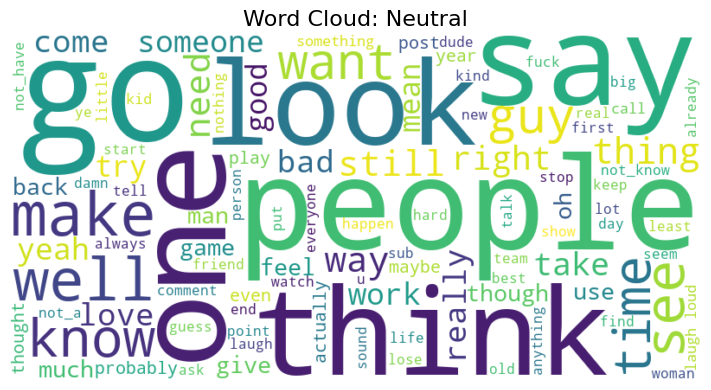

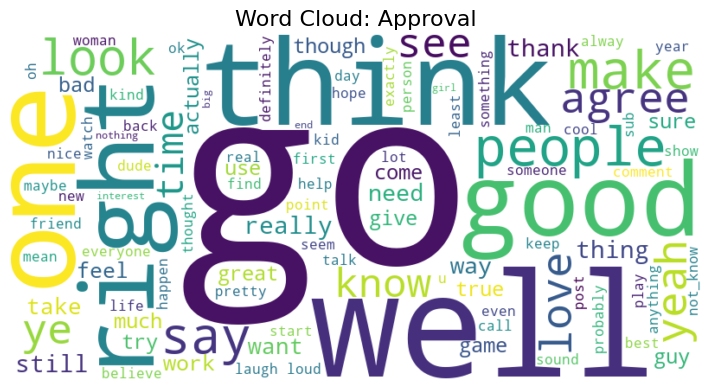

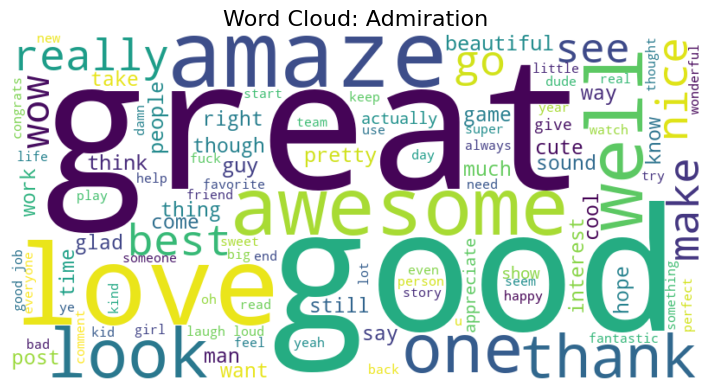

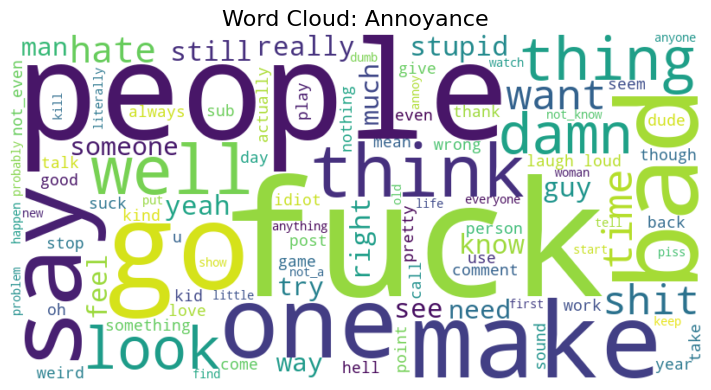

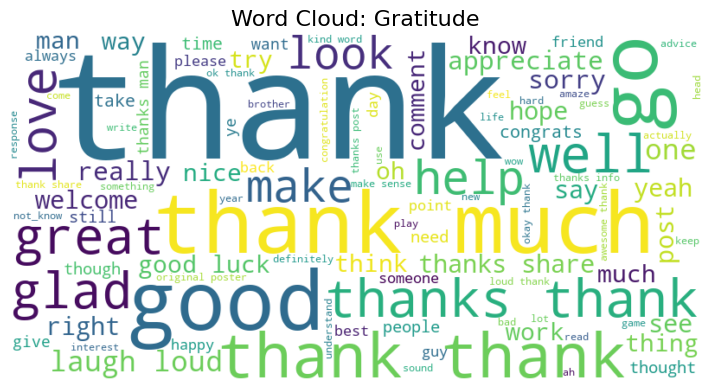

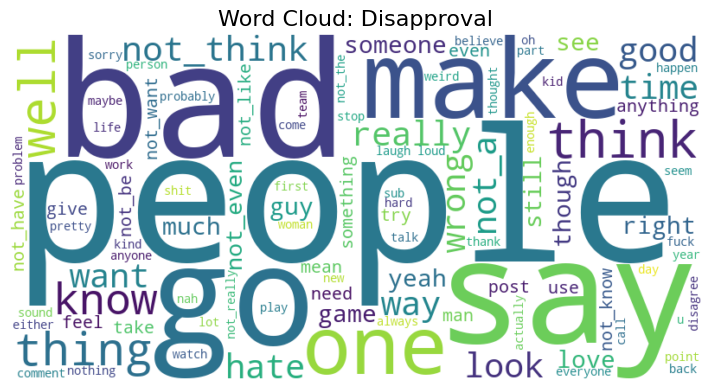

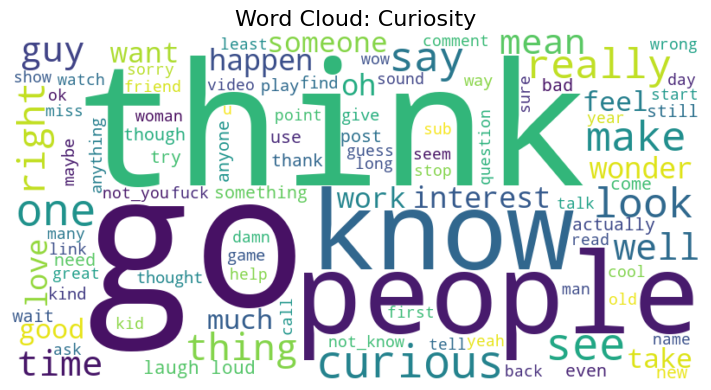

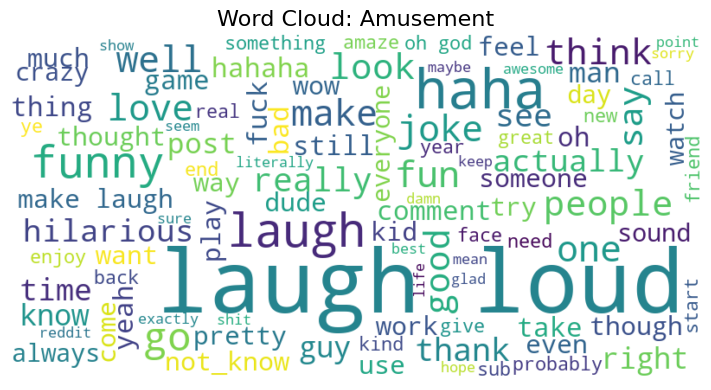

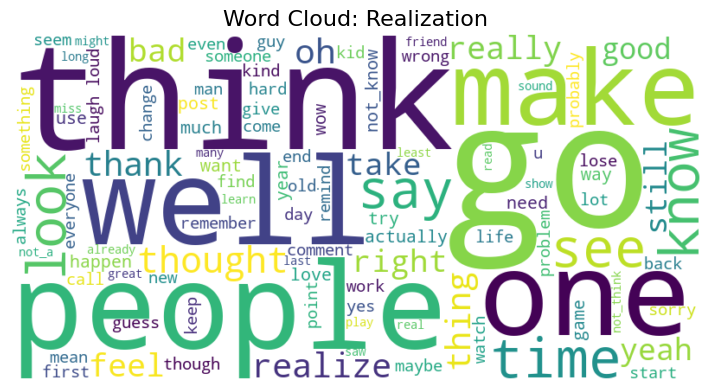

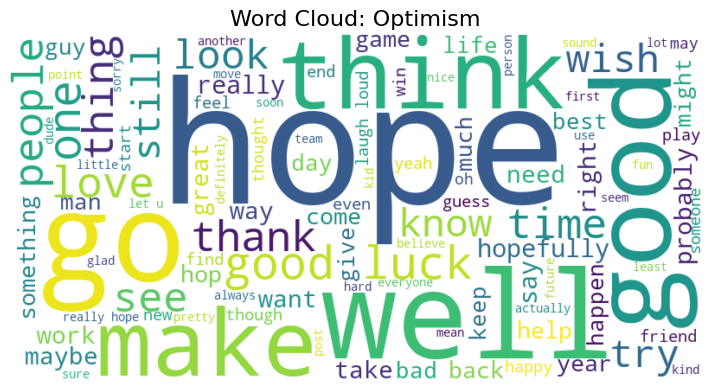

In [ ]:
print("\n" + "="*50)
print("Text Analysis")
print("="*50)

# Count the frequency of each emotion (sum column-wise)
emotion_freq = pd.DataFrame(df['vector'].tolist(), columns=emotion_columns).sum().sort_values(ascending=False)

def generate_word_cloud_from_tokens(emotion, max_words=100):
    # Filter rows where this emotion is present
    emotion_rows = df[df['vector'].apply(lambda x: x[emotion_columns.index(emotion)] == 1)]
    
    # Flatten list of tokens into one big list
    all_tokens = [token for tokens in emotion_rows['filtered_tokens'] for token in tokens]
    text = " ".join(all_tokens)  # Combine into one string

    # Generate and plot word cloud
    plt.figure(figsize=(8, 4))
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white',
                          max_words=max_words).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud: {emotion.capitalize()}', fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate for top 5 and bottom 5 emotions
for emotion in emotion_freq.index[:10]:
    generate_word_cloud_from_tokens(emotion)

---
# 4.0 Data splitting
Using Iterative Stratified Splitting
- 70% Train set
- 15% Test set
- 15% Validation set

In [3]:
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Configuration
RARE_EMOTIONS = ['grief', 'pride', 'relief', 'nervousness', 'remorse', 'embarrassment', 'fear', 'desire']
AUGMENTATION_FACTOR = 5
MIN_SAMPLES = 500
NEUTRAL_DOWNSAMPLE_RATIO = 0.5

# Load and Prepare Labels
y = np.array(df['vector'].tolist())
neutral_idx = emotion_columns.index('neutral')

# Identify samples that are only labeled as neutral
only_neutral_mask = (
    np.all(y[:, :neutral_idx] == 0, axis=1) &
    np.all(y[:, neutral_idx + 1:] == 0, axis=1) &
    (y[:, neutral_idx] == 1)
)

# Downsample pure neutral samples 
neutral_indices = np.where(only_neutral_mask)[0]
non_neutral_indices = np.where(~only_neutral_mask)[0]
keep_count = int(len(neutral_indices) * NEUTRAL_DOWNSAMPLE_RATIO)
selected_neutral = np.random.choice(neutral_indices, keep_count, replace=False)

# Combine and shuffle
balanced_indices = np.concatenate([non_neutral_indices, selected_neutral])
np.random.shuffle(balanced_indices)
y_balanced = y[balanced_indices]
balanced_dataset_indices = np.arange(len(y_balanced)) 

In [4]:
# Iterative Stratified Splitting (Train/Val/Test)

# First split: Train (70%) / Temp (30%)
stratifier_train_temp = IterativeStratification(
    n_splits=2, order=2, sample_distribution_per_fold=[0.7, 0.3]
)
train_balanced_idx, temp_balanced_idx = next(stratifier_train_temp.split(balanced_dataset_indices, y_balanced))

# Second split: Val (15%) / Test (15%) from Temp
stratifier_val_test = IterativeStratification(
    n_splits=2, order=2, sample_distribution_per_fold=[0.5, 0.5]
)
temp_sub_indices = np.arange(len(temp_balanced_idx))
val_balanced_sub_idx, test_balanced_sub_idx = next(
    stratifier_val_test.split(temp_sub_indices, y_balanced[temp_balanced_idx])
)

# Map back to original indices
train_indices = balanced_indices[train_balanced_idx]
val_indices = balanced_indices[temp_balanced_idx[val_balanced_sub_idx]]
test_indices = balanced_indices[temp_balanced_idx[test_balanced_sub_idx]]

In [5]:
# Create DataFrames for Each Split
train_df = df.iloc[train_indices].copy()
val_df = df.iloc[val_indices].copy()
test_df = df.iloc[test_indices].copy()

# Extract emotion labels for readability
def vector_to_labels(vector):
    return [emotion_columns[i] for i, val in enumerate(vector) if val == 1]

for df_split in [train_df, val_df, test_df]:
    df_split['emotion'] = df_split['vector'].apply(vector_to_labels)
    df_split['sample_weight'] = 1.0
    df_split['is_augmented'] = True

In [6]:
# Data augmentation: Synonym Replacement
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word and len(synonym.split()) == 1:  # Only single-word synonyms
                synonyms.add(synonym)
    return list(synonyms)

def synonym_replacement(tokens, n=2):
    """Replace n random words with synonyms"""
    new_tokens = tokens.copy()
    valid_indices = [i for i, word in enumerate(tokens) if get_synonyms(word)]
    
    if not valid_indices or len(valid_indices) < n:
        return tokens  # Not enough replaceable words
    
    # Randomly select indices to replace
    indices_to_replace = random.sample(valid_indices, n)
    
    for idx in indices_to_replace:
        word = tokens[idx]
        synonyms = get_synonyms(word)
        if synonyms:
            new_tokens[idx] = random.choice(synonyms)
    
    return new_tokens

In [7]:
# Data Augmentation: Synonym Replacement
augmented_samples = []

for _, row in train_df.iterrows():
    emotions = row['emotion']
    augment_rare = any(e in RARE_EMOTIONS for e in emotions)
    augment_non_neutral = 'neutral' not in emotions
    boost_factor = 1.5 if augment_rare else 1.2
    boost_count = AUGMENTATION_FACTOR if augment_rare else 1

    if augment_rare or augment_non_neutral:
        for _ in range(boost_count):
            n_replace = random.choice([1, 1, 2, 2, 3])
            aug_tokens = synonym_replacement(row['filtered_tokens'], n=n_replace)
            augmented_text = " ".join(aug_tokens)

            augmented_samples.append({
                'text': augmented_text,
                'filtered_tokens': aug_tokens,
                'vector': row['vector'],
                'emotion': row['emotion'],
                'sample_weight': row['sample_weight'] * boost_factor,
                'is_augmented': True
            })

# Add augmented samples to training data

if augmented_samples:
    augmented_df = pd.DataFrame(augmented_samples)
    train_df = pd.concat([train_df, augmented_df], ignore_index=True) 

In [8]:
# Extract Data for Modeling
X_train = train_df['filtered_tokens'].values
X_val = val_df['filtered_tokens'].values
X_test = test_df['filtered_tokens'].values

y_train = np.array(train_df['vector'].tolist())
y_val = np.array(val_df['vector'].tolist())
y_test = np.array(test_df['vector'].tolist())

train_weights = train_df['sample_weight'].values

In [9]:
# Print Distribution Summary
def print_distribution(y, name, total_samples):
    print(f"\n{name} Set Distribution ({total_samples} samples):")
    for i, emotion in enumerate(emotion_columns):
        count = np.sum(y[:, i])
        print(f"- {emotion}: {count} ({count/total_samples*100:.2f}%)")

print_distribution(y_train, "Augmented Train", len(X_train))
print_distribution(y_val, "Validation", len(X_val))
print_distribution(y_test, "Test", len(X_test))


Augmented Train Set Distribution (119269 samples):
- admiration: 11070 (9.28%)
- amusement: 5826 (4.88%)
- anger: 5118 (4.29%)
- annoyance: 8666 (7.27%)
- approval: 11224 (9.41%)
- caring: 3960 (3.32%)
- confusion: 4652 (3.90%)
- curiosity: 6276 (5.26%)
- desire: 6870 (5.76%)
- disappointment: 5862 (4.91%)
- disapproval: 7222 (6.06%)
- disgust: 3636 (3.05%)
- embarrassment: 4458 (3.74%)
- excitement: 3614 (3.03%)
- fear: 5754 (4.82%)
- gratitude: 7540 (6.32%)
- grief: 1212 (1.02%)
- joy: 5170 (4.33%)
- love: 5282 (4.43%)
- nervousness: 3258 (2.73%)
- optimism: 6054 (5.08%)
- pride: 2346 (1.97%)
- realization: 5714 (4.79%)
- relief: 2322 (1.95%)
- remorse: 4548 (3.81%)
- sadness: 4986 (4.18%)
- surprise: 3524 (2.95%)
- neutral: 8295 (6.95%)

Validation Set Distribution (62967 samples):
- admiration: 5996 (9.52%)
- amusement: 3236 (5.14%)
- anger: 2830 (4.49%)
- annoyance: 4767 (7.57%)
- approval: 6167 (9.79%)
- caring: 2100 (3.34%)
- confusion: 2575 (4.09%)
- curiosity: 3392 (5.39%)
- 

---
# 5.0 Models Development

## 5.1 Transformers
- DistilBERT


In [20]:
# Define parameters
max_len = 64
batch_size = 32
epochs = 3

In [11]:
# Convert tokens back to text for Transformers
X_train_trans = [' '.join(tokens) for tokens in X_train]
X_val_trans = [' '.join(tokens) for tokens in X_val]
X_test_trans = [' '.join(tokens) for tokens in X_test]

In [12]:
# Prepare labels (multi-label format)
mlb = MultiLabelBinarizer()
y_train_mlb = mlb.fit_transform(train_df['emotion'])
y_val_mlb = mlb.transform(val_df['emotion'])
y_test_mlb = mlb.transform(test_df['emotion'])

num_classes = len(mlb.classes_)
emotion_columns = mlb.classes_

In [13]:
# Function for tokenization
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

In [14]:
# Create a custom Dataset class for PyTorch
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    def __len__(self):
        return len(self.labels)

In [15]:
# Function to train Transformers model
def train_transformers_model(model, train_loader, val_loader, 
                            model_name, emotion_columns, epochs):
    print(f"=== {model_name} ===")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Initialize optimizer
    optimizer = AdamW(model.parameters(), lr=5e-5)
    
    # Storage for metrics
    train_losses = []
    val_losses = []
    val_metrics = {
        'hamming_loss': [],
        'jaccard_score': [],
        'f1_micro': []
    }
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_train_loss = 0.0
        
        # Progress bar setup
        total_batches = len(train_loader)
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        for batch_idx, batch in enumerate(train_loader):
            optimizer.zero_grad()
            
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            # Forward pass and loss calculation
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            
            # Print progress
            progress = (batch_idx + 1) / total_batches
            bar_length = 30
            filled_length = int(bar_length * progress)
            bar = '=' * filled_length + ' ' * (bar_length - filled_length)
            print(f"\r{bar} | Batch {batch_idx+1}/{total_batches} | Train Loss: {loss.item():.4f}", end='')
        
        # Calculate average training loss
        avg_train_loss = epoch_train_loss / total_batches
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                # Forward pass and loss calculation (single pass)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                epoch_val_loss += loss.item()
                # Get predictions
                preds = torch.sigmoid(outputs.logits).cpu().numpy()
                all_preds.append(preds)
                all_labels.append(labels.cpu().numpy())
        
        # Calculate validation metrics
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)
        all_preds_bin = (all_preds > 0.5).astype(int)

        print(f"\nEpoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        val_f1 = f1_score(all_labels, all_preds_bin, average='micro')
        # Store validation metrics
        val_metrics['hamming_loss'].append(hamming_loss(all_labels, all_preds_bin))
        val_metrics['jaccard_score'].append(jaccard_score(all_labels, all_preds_bin, average='samples'))
        val_metrics['f1_micro'].append(val_f1)

        
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_metrics': val_metrics
    }

In [22]:
# Function to evaluate Transformers model 
def evaluate_transformers_model(model, history, test_loader, emotion_columns, model_name):  
    print(f"=== {model_name} ===")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    model.eval()
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.sigmoid(outputs.logits).cpu().numpy()
            test_preds.append(preds)
            test_labels.append(labels.cpu().numpy())
    
    test_preds = np.vstack(test_preds)
    test_labels = np.vstack(test_labels)
    test_preds_bin = (test_preds > 0.5).astype(int)  # 3. Use only test_preds
    
    # Calculate test metrics
    test_hamming = hamming_loss(test_labels, test_preds_bin)
    test_jaccard = jaccard_score(test_labels, test_preds_bin, average='samples')
    test_f1 = f1_score(test_labels, test_preds_bin, average='micro')
    
    print(f"\n=== {model_name} ===")
    print(f"Test Hamming Loss: {test_hamming:.4f}")
    print(f"Test Jaccard Score: {test_jaccard:.4f}")
    print(f"Test Micro F1-Score: {test_f1:.4f}")
    
    # Classification report
    print(f"\nClassification Report ({model_name}):\n")
    print(classification_report(test_labels, test_preds_bin, target_names=emotion_columns, zero_division=0))
        
    # Plot F1 scores per emotion
    f1_scores = []
    for i in range(len(emotion_columns)):
        f1 = f1_score(test_labels[:, i], test_preds_bin[:, i])
        f1_scores.append(f1)
    plt.figure(figsize=(7, 5))
    sns.barplot(y=emotion_columns, x=f1_scores, palette="viridis")
    plt.title(f"F1 Scores per Emotion - {model_name}")
    plt.xlabel("F1 Score")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(6, 4))
    # Loss plot
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return {
        'hamming_loss': test_hamming,
        'jaccard_score': test_jaccard,
        'f1_micro': test_f1
    }


In [17]:
# Initialize tokenizer
distilbert_tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenize texts for train, validation, and test sets
train_encodings = tokenize_texts(X_train_trans, distilbert_tokenizer)
val_encodings = tokenize_texts(X_val_trans, distilbert_tokenizer)
test_encodings = tokenize_texts(X_test_trans, distilbert_tokenizer)

In [18]:
# Create datasets for train, validation, and test
train_dataset = EmotionDataset(train_encodings, y_train_mlb)
val_dataset = EmotionDataset(val_encodings, y_val_mlb)
test_dataset = EmotionDataset(test_encodings, y_test_mlb)

# Training configuration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# DistilBERT model 
num_labels = y_train_mlb.shape[1]
model_distilbert = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels = num_labels,
    problem_type = "multi_label_classification"
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Train and validate DistilBERT model
distilbert_model, distilbert_history = train_transformers_model(
    model=model_distilbert,
    train_loader = train_loader,
    val_loader = val_loader,
    model_name = "DistilBERT",
    emotion_columns = emotion_columns,
    epochs = epochs
)

=== DistilBERT ===

Epoch 1/3
============================== | Batch 7455/7455 | Train Loss: 0.0968
Epoch 1 | Train Loss: 0.1456 | Val Loss: 0.1340

Epoch 2/3
============================== | Batch 7455/7455 | Train Loss: 0.1606
Epoch 2 | Train Loss: 0.1156 | Val Loss: 0.1394

Epoch 3/3
============================== | Batch 7455/7455 | Train Loss: 0.1434
Epoch 3 | Train Loss: 0.0934 | Val Loss: 0.1524


=== DistilBERT ===

=== DistilBERT ===
Test Hamming Loss: 0.0467
Test Jaccard Score: 0.2441
Test Micro F1-Score: 0.3229

Classification Report (DistilBERT):

                precision    recall  f1-score   support

    admiration       0.55      0.51      0.53      5996
     amusement       0.58      0.60      0.59      3236
         anger       0.40      0.27      0.32      2829
     annoyance       0.28      0.14      0.19      4766
      approval       0.35      0.14      0.20      6167
        caring       0.37      0.13      0.19      2099
     confusion       0.31      0.21      0.25      2576
     curiosity       0.36      0.19      0.25      3392
        desire       0.26      0.28      0.27      1336
disappointment       0.29      0.08      0.12      2964
   disapproval       0.30      0.17      0.21      3999
       disgust       0.47      0.12      0.19      1856
 embarrassment       0.21      0.18      0.19       867
    excitement       0.34      0.11      0.17      1970
 

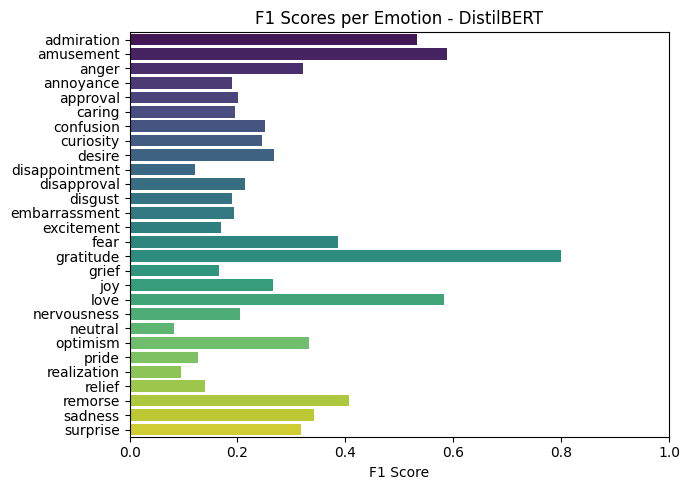

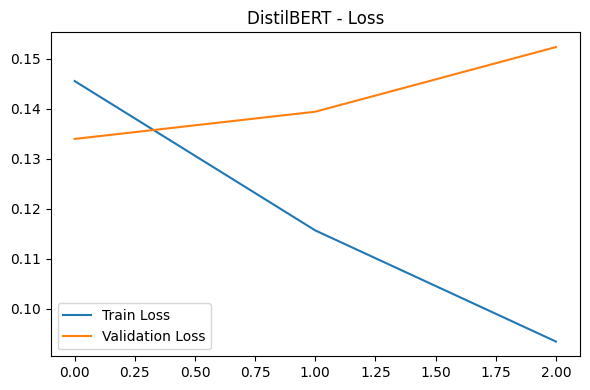

In [23]:
# Evaluate on test set 
distilbert_metrics = evaluate_transformers_model(
    distilbert_model, 
    distilbert_history,
    test_loader, 
    emotion_columns, 
    model_name="DistilBERT",
)

---
# 6.0 Deployment

In [ ]:
# Save DistilBERT model and metadata
model_dir = Path("distilbert")
model_dir.mkdir(exist_ok=True)

# Save individual models
distilbert_model.save_pretrained(model_dir/"distilbert_model")

# Save tokenizers
distilbert_tokenizer.save_pretrained(model_dir/"distilbert_tokenizer")

# Save label binarizer
joblib.dump(mlb, model_dir / "label_binarizer.pkl")

# Save metadata 
metadata = {
    "max_len": max_len,
    "num_labels": num_labels,
}
with open(model_dir/"metadata.pkl", "wb") as f:
    pickle.dump(metadata, f)